# classical Ising gauge theory in 2D
* In this note we won't use machine learning methods to classify phases of the system, but directly rely on knowledge of the Hamiltonian and the topological Wilson loop.


In [1]:
import numpy as np
from IPython.display import Image

# Read in the spin configurations:

In [2]:
fileName  = 'gaugeTheoryConfigs.txt'          # The file where the configurations are stored
configs   = np.loadtxt(fileName,dtype='int8') # Read the data from file

In [8]:
configs[0]

1

In [4]:
N_configs = configs.shape[0]                  # Total number of configurations given
N_spins   = configs.shape[1]                  # Total number of spins per configuration
N_sites   = int(N_spins/2)                    # Total number of lattice sites
L         = int(np.sqrt(N_sites))             # Linear size of the lattice
J         = 1                                 # Coupling parameter

Test the index of spins for plaquette without b.c.

In [212]:
site = 14
[2*site, 2*site+1, 2*site+3, 2*site+2*4]

[28, 29, 31, 36]

# Example of L = 4 configuration

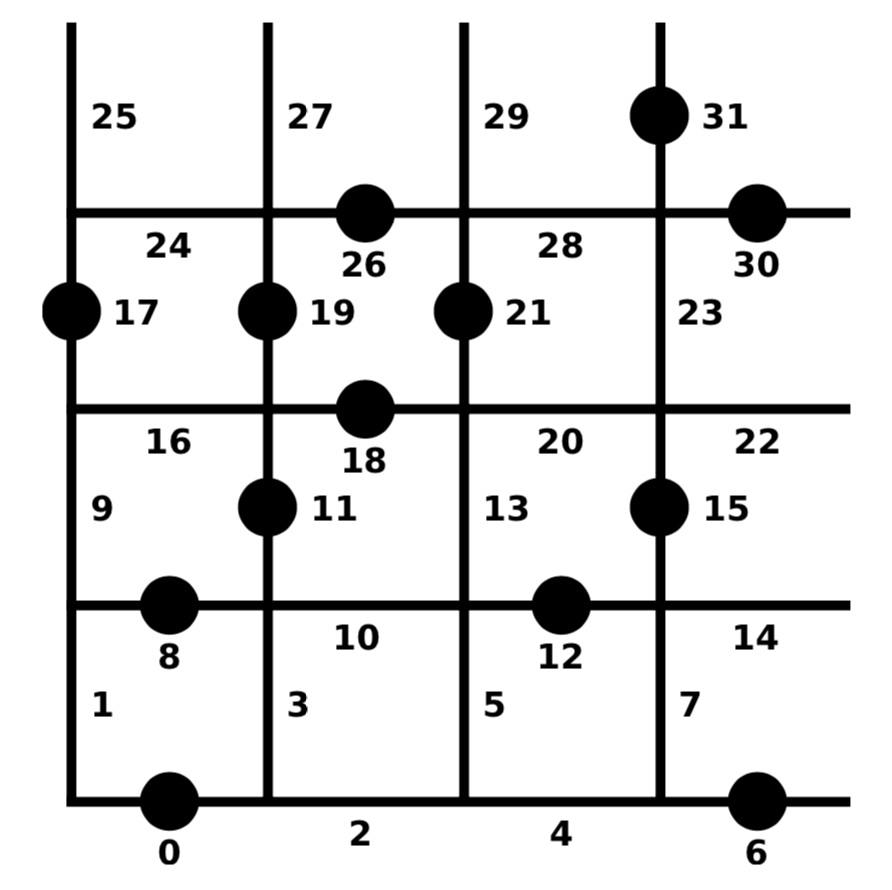

In [111]:
Image(filename="tut2.png",width=300,height=300)

# (1) Calculate energy by $H = -J\sum_{\text{plaq. p}}\{\Pi_{i\in p}s_{i}\}$ and pick out the ground states in the dataset by examing their energy

To calculate the energy of the lattice, we sum up all plaquette's energy. We can assign each plaquette an index by its bottom-left corner site.  

First, we examine the index of lattice site for L=4

In [257]:
site = 7
(int(site/4), site%4 )

(1, 3)

Then, we obtain the spin index for plaquette given a site. (without b.c.)

In [258]:
site = 14
[2*site, 2*site+1, 2*site+3, 2*site+2*4]

[28, 29, 31, 36]

Combine the above to build a function generating the spin index.(Taking care of b.c in the function) 

In [259]:
# The function that calculate the spin indices of plaquettes
# input: Length of the lattice L ; ith lattice site
# output: four spin indices of this plaquette
def plaquette_spin_index(L, site):
     
    lattice_site_index = (int(site/L), site%L ) 
    # The lattice site, we use it to represent the plaquette
    
    spin_index = [2*site, 2*site+1, 2*site+3, 2*site+2*L]
    # Spin index of this plaquette: [bottom, left, right, up] , before imposing b.c.
    
    if lattice_site_index[0] == (L-1):                # Impose periodic b.c. to upper boundary
        
        spin_index[3] = 2*lattice_site_index[1]
        
    if lattice_site_index[1] == (L-1):                # Impose periodic b.c. to right boundary
        
        spin_index[2] = 2*L*lattice_site_index[0] + 1
    
    return spin_index
    

Test this function for L=4 case

In [261]:
for site in range(16):
    print(plaquette_spin_index(4, site))

[0, 1, 3, 8]
[2, 3, 5, 10]
[4, 5, 7, 12]
[6, 7, 1, 14]
[8, 9, 11, 16]
[10, 11, 13, 18]
[12, 13, 15, 20]
[14, 15, 9, 22]
[16, 17, 19, 24]
[18, 19, 21, 26]
[20, 21, 23, 28]
[22, 23, 17, 30]
[24, 25, 27, 0]
[26, 27, 29, 2]
[28, 29, 31, 4]
[30, 31, 25, 6]


In [42]:
# Function that calculate the energy of a single plaquette 
def energy_plaquette(state, i_th_plaq):
    
    L = int(np.sqrt(int(len(state)/2)))
    
    spin_index = plaquette_spin_index(L, i_th_plaq)
    
    energy = -state[spin_index[0]]*state[spin_index[1]]*state[spin_index[2]]*state[spin_index[3]]
    
    return energy

In [49]:
# Function that calculate the total energy of a given state
def energy_state(state):
    
    E = 0
    
    for plaq in range(N_sites):
        
        E += energy_plaquette(state, plaq) 
        
    return E    

# Collecting energies of all datas:

In [116]:
E = []
count = 0
ground_state_label = []
for c in range(N_configs):
    
    state = configs[c]  # A numpy array of length N_spins that store a spin configuration
    
    energy = J*energy_state(state)
    
    if energy == -289:
        count += 1
        ground_state_label.append(c)
    E.append(energy)

In [117]:
print("Ground state energy is ", min(E))
print("Ground states in this dataset are ", ground_state_label)

Ground state energy is  -289
Ground states in this dataset are  [3609, 3610, 3611, 3619, 3622, 3623, 5025, 5029, 5031, 5035, 5036, 5037, 6561, 6562, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 9144, 9145, 9146, 9147, 9997, 9998, 9999]


Thus, there are 28 configurations with ground state energy

# (2) Use Wilson Loop $W_{C}$ to distinguish topological order of states.

Calculate $W_{C_{x}}$ and $W_{C_{y}}$ for each of the contour through x-axis and y-axis respectively.

 Where  $W_{C}=\Pi_{i\in C}s_{i}$

A state is topological ordered $\iff$ $W_{C_{x}}$ and $W_{C_{y}}$ are constants for all contour $C_{x}$, $C_{y}$

In [97]:
# input: length of lattice L; a list contour = [axis: 0 for x and 1 for y, ith contour of this axis]
# output: the spin indices of the entire contour
def contour_index(L, contour):
    index = np.zeros(L)
    c = contour[1]
    if contour[0] == 0:             ## contour is Cx
        for i in range(L):
            index[i] = (c-1)*2*L + 2*i
    if contour[0] == 1:             ## contour is Cy
        for i in range(L):
            index[i] = (c-1)*2 + 2*i*L + 1
     
    return index

In [98]:
contour_index(5, [1,2])

array([ 3., 13., 23., 33., 43.])

In [104]:
# Compute Wilson loop Wc along one contour
# input: a list state; a list contour = [axis, ith contour of this axis]
# output: value of wilson loop along this contour
def one_contour_wilson(state, contour):
    L = int(np.sqrt(int(len(state)/2)))
    w_loop = 1
    
    for i in range(L):
        w_loop *= state[int(contour_index(L, contour)[i])] 
    
    return w_loop

In [105]:
one_contour_wilson(configs[1], [0, 5])

-1

In [106]:
# Compute all Wilson loop Wc along of the state
# input: state
# output: all Wilson loop of this state
def all_contour_wilson(state):
    L = int(np.sqrt(int(len(state)/2)))
    W_c_x = []
    W_c_y = []
    for c in range(L):
        w_loop_x = one_contour_wilson(state, [0, c])
        w_loop_y = one_contour_wilson(state, [0, c])
        W_c_x.append(w_loop_x)
        W_c_y.append(w_loop_y)
    return  W_c_x , W_c_y

In [122]:
all_contour_wilson(configs[3619])

([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

# Collect all states:

In [ ]:
for c in range(N_configs):
    
    state = configs[c]  # A numpy array of length N_spins that store a spin configuration
    

# (3) Generate topological ordered states 

* Start from all-spin-up state. i.e. $s_{i}=1, i\in N$
* Apply gauge transformation(update) to this state to arrive a new topological ordered state.
* (Trick) Apply the above update sufficient times over randomly chosen lattice sites to make sure the new state is different.
* Write new states to txt file with the same format as gaugeTheoryConfigs.txt we used above.

In [169]:
init_state = np.ones(N_spins)

To update the all-spin-up state, we first build a function that given site i , it can pick up the four spins to be flipped. 

Given some site index, try obtain the index of spins connected by that site with b.c. 

In [241]:
site = 12
L_test = 4
print([2*site, 2*site+1, 2*(site-1), 2*(site-L_test)+1])
if site%L_test == 0:
    print('modify the 3rd index to', (L_test-1)*2+ int(site/L_test)*2*L_test)
    
if int(site/L_test) == 0:
    print('modify the 4th index to', site*2+1+2*L_test*(L_test-1))

[24, 25, 22, 17]
modify the 3rd index to 30


Use this to build a function generating spin index.

In [242]:
# The function that produces the indices of spins connected by one site
# input: Length of the lattice L ; ith lattice site
# output: four spin indices
def connected_spin_index(L, site):
    lattice_site_index = (int(site/L), site%L ) 
    # The lattice sites, from (0,0), (0,1) to (L-1,L-1) of total # N_sites of lattice sites.
    
    spin_index = [2*site, 2*site+1, 2*(site-1), 2*(site-L)+1]
    # Spin index connected to the chosen site: [right, up, left, down] , before imposing b.c.
    
    if lattice_site_index[1] == 0:                # Impose periodic b.c. to upper boundary
        
        spin_index[2] = (L-1)*2+ lattice_site_index[0]*2*L
        
    if lattice_site_index[0] == 0:                # Impose periodic b.c. to right boundary
        
        spin_index[3] = site*2 + 1 + 2*L*(L-1)
    
    return spin_index

Test this function for L=4 case

In [262]:
for site in range(16):
    print(connected_spin_index(4, site))

[0, 1, 6, 25]
[2, 3, 0, 27]
[4, 5, 2, 29]
[6, 7, 4, 31]
[8, 9, 14, 1]
[10, 11, 8, 3]
[12, 13, 10, 5]
[14, 15, 12, 7]
[16, 17, 22, 9]
[18, 19, 16, 11]
[20, 21, 18, 13]
[22, 23, 20, 15]
[24, 25, 30, 17]
[26, 27, 24, 19]
[28, 29, 26, 21]
[30, 31, 28, 23]


To apply gauge transformation on a given state, we build a function.

In [331]:
def GaugeTransform(state, site):
    spin_index = connected_spin_index(L, site)
    # We define another initial state because arrays in python are like pointers not variables, and 
    # changing new state will also change initial state if we just bound initial state to new state.  
    state_new = np.ones(N_spins)
    state_new[spin_index[0]] = state[spin_index[0]]*(-1)
    state_new[spin_index[1]] = state[spin_index[1]]*(-1)
    state_new[spin_index[2]] = state[spin_index[2]]*(-1)
    state_new[spin_index[3]] = state[spin_index[3]]*(-1)
    return state_new

To generate numerous new states without repeating states, we have to randomly pick a site N_spins times to generate one new state. Do this N times, we can reasonably generate N new states.

In [279]:
import random

Produce a random list of sites

In [280]:
site_list = random.sample(range(N_sites), N_sites)

We can now define function doing gauge transformation on multiple sites.

In [ ]:
configs_ordered = np.zeros((N_configs, N_spins))
configs_ordered[0]=init_state

In [348]:
def GaugeTransform_multi_site(state, site_list):
    for site in site_list:
        state_new = GaugeTransform(state, site)
    return state_new

Now we can generate N_configs new states

In [352]:
for i in range(N_configs):
    
    site_list = random.sample(range(N_sites), N_sites)
    configs_ordered[i] = GaugeTransform_multi_site(init_state, site_list)

Now we have N_configs new states stored in array configs_ordered, and we can check if all of them are topological ordered, in fact, in this case $W_{C_{x}}= W_{C_{y}}= 1$

In [367]:
check_list = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]

In [373]:
count = 0
for i in range(N_configs):
    if all_contour_wilson(configs_ordered[i])[0] == check_list and all_contour_wilson(configs_ordered[i])[1] == check_list:
        count += 1

In [374]:
count

10000

# (4) Generate new states breaking topological ordered

We can design a transformation on state and see if it break the topological order 

In [385]:
def Transform(state, index):
    state_new = np.ones(N_spins)
    state_new[index[0]] = state[index[0]]*(-1)
    state_new[index[1]] = state[index[1]]*(-1)
    state_new[index[2]] = state[index[2]]*(-1)
    state_new[index[3]] = state[index[3]]*(-1)
    state_new[index[4]] = state[index[3]]*(-1)
    return state_new

In [387]:
index_random = random.sample(range(N_sites), 5)
f_state = Transform(init_state, index_random)

In [390]:
all_contour_wilson(f_state)

([1.0,
  1.0,
  1.0,
  1.0,
  -1.0,
  1.0,
  1.0,
  1.0,
  -1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  -1.0,
  1.0,
  1.0,
  1.0,
  -1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

In [392]:
configs_unordered = np.zeros((N_configs, N_spins))

In [393]:
for i in range(N_configs):
    index_random = random.sample(range(N_sites), 5)
    configs_unordered[i] = Transform(init_state, index_random)

In [394]:
count = 0
for i in range(N_configs):
    if all_contour_wilson(configs_unordered[i])[0] == check_list and all_contour_wilson(configs_unordered[i])[1] == check_list:
        count += 1

In [395]:
count

731

# (5) Write the generated states to a txt file